In [31]:
import pandas as pd
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from scipy.stats import wilcoxon

In [3]:
# https://www.cryptoarchive.com.au/asset/DOGE --> Doge EUR
folderpath = "../../Data/QMEF/"

df = pd.read_csv(folderpath + 'BTCUSDT.csv', sep='|', header=None)

# https://www.cryptoarchive.com.au/faq
df.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Taker Buy Quote Asset Volume', 
                'Taker Buy Base Asset Volume', 'Quote Asset Volume', 'Number of trades']
# Quote Asset Volume verwenden. Volume ist im Verhältnis zu BTC.

df

,timestamp,Open,High,Low,Close,Volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
0,1502942400,4261.48,4261.48,4261.48,4261.48,1.775183,320.390851,0.075183,7564.906851,3
1,1502942460,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0.000000,0.000000,0
2,1502942520,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,0.261074,1117.542921,2
3,1502942580,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,0.012008,51.171852,3
4,1502942640,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,0.140796,599.999338,1
...,...,...,...,...,...,...,...,...,...,...
3120426,1690681620,29325.90,29325.91,29325.90,29325.91,1.199590,5545.822840,0.189110,35179.058270,108
3120427,1690681680,29325.91,29325.91,29324.60,29324.72,3.922770,34683.135800,1.182680,115038.629410,140
3120428,1690681740,29324.72,29324.73,29324.72,29324.72,0.562730,10083.601660,0.343860,16501.903120,106
3120429,1690681800,29324.73,29327.67,29324.72,29327.67,3.839800,98416.039460,3.355980,112605.116370,235


In [83]:
# Ich muss in der Tweet-Analyse nochmal mit neuen Keywords die Bitcoin-Tweets finden und separat abspeichern.
# // TODO: Bitcoin-Tweets speichern.

df_tweets = pd.read_csv("../../Data/QMEF/btc_tweet_analysis.csv", sep=";", encoding='utf8', parse_dates=['CreatedAt', 'UTC'])
df_tweets.drop_duplicates('TweetId', inplace = True)

df_tweets['timestamp'] = df_tweets['UTC'].apply(lambda x: x.astype('int')//10**9)
df_tweets['timestamp'] = df_tweets['timestamp'] - (df_tweets['timestamp'] % 60) #Abrunden auf Minuten

df_tweets = df_tweets[['UTC', 'timestamp', 'Text', 'Favorites', 'Retweets', 'neg', 'neu', 'pos', 'compound']]
# df_tweets = df_tweets.merge(df_doge, left_on='Date', right_on='Date')
# df_tweets_relevant = df_tweets.loc[(df_tweets['Favorites'] >= 500_000) & (df_tweets['Retweets'] >= 50_000)].copy()

df_tweets['UTC'] = pd.to_datetime(df_tweets['UTC'])
# Zeitdauer von 6 Stunden
time_threshold = timedelta(hours=6)

# Liste für Zeilen, die behalten werden sollen
df_tweets_relevant = []

# Iteriere über jeden Eintrag im DataFrame
for index, row in df_tweets.iterrows():
    utc_time = row['UTC']
    
    # Überprüfe die Differenz zur 'UTC'-Spalte aller anderen Einträge
    time_difference = abs(df_tweets.loc[df_tweets.index != index, 'UTC'] - utc_time)
    
    # Wenn die Differenz größer oder gleich 6 Stunden ist, behalte den Eintrag
    if (time_difference >= time_threshold).all():
        df_tweets_relevant.append(index)

# Filtere den DataFrame nach den ausgewählten Zeilen
df_tweets_relevant = df_tweets.loc[df_tweets_relevant]
pd.set_option('display.max_colwidth', None)
print(df_tweets_relevant['Text'])


0                                                                                                                                                                                        @PeterSchiff That said, BTC &amp; ETH do seem high lol
1                                                                                                                                                                                             @Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶
2    @itsALLrisky Doge appears to be inflationary, but is not meaningfully so (fixed # of coins per unit time), whereas BTC is arguably deflationary to a fault.  Transaction speed of Doge should ideally be a few orders of magnitude faster.
3                                              @stoolpresidente No, you do not. I have not sold any of my Bitcoin. Tesla sold 10% of its holdings essentially to prove liquidity of Bitcoin as an alternative to holding cash on balance sheet.
4                                       

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0


Expected Return =  -4.4900623832960184e-05
T[0; 1] =  -2.836445994005796
T[0; 5] =  -3.094643583714738
T[0; 10] =  -3.734198940157742
T[0; 30] =  -0.9604948393673636
T[0; 60] =  -0.9437074988672255
T[0; 120] =  -0.5544413551598847


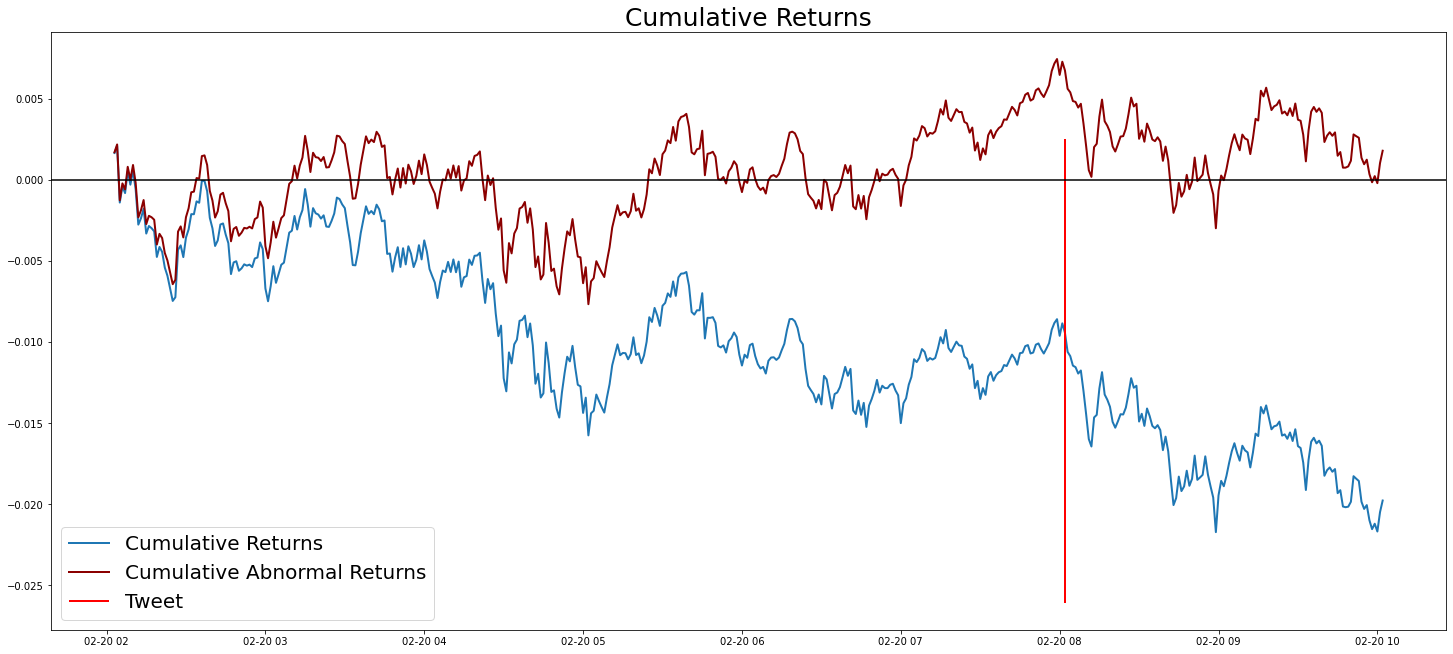

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0


Expected Return =  7.48480378579025e-05
T[0; 1] =  -0.2556507008871264
T[0; 5] =  -0.26290013071478296
T[0; 10] =  -0.7462742483472293
T[0; 30] =  -0.45883013295583497
T[0; 60] =  -0.5101396371500473
T[0; 120] =  -1.1265496458902193


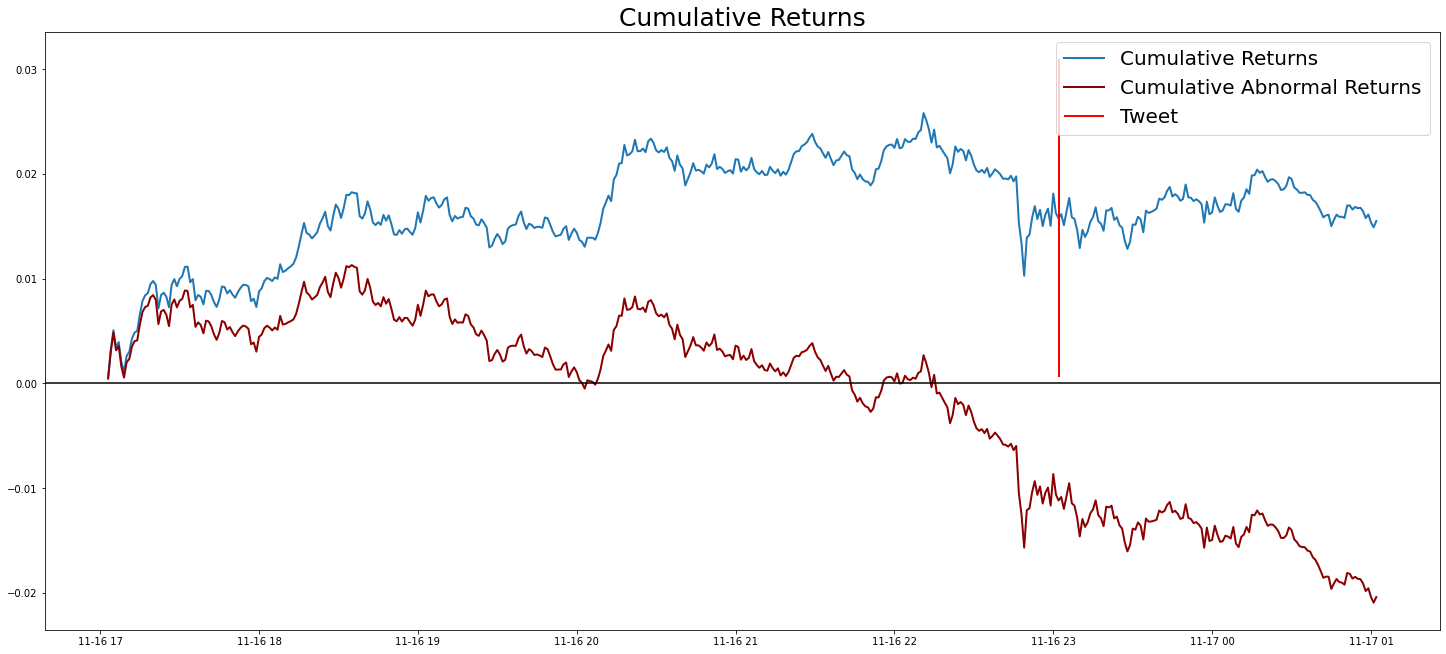

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0


Expected Return =  -3.277347509483498e-05
T[0; 1] =  0.08981227202905842
T[0; 5] =  0.6144135280426424
T[0; 10] =  1.191650123233049
T[0; 30] =  0.4590816956017414
T[0; 60] =  2.2968312558025494
T[0; 120] =  1.4921177983014473


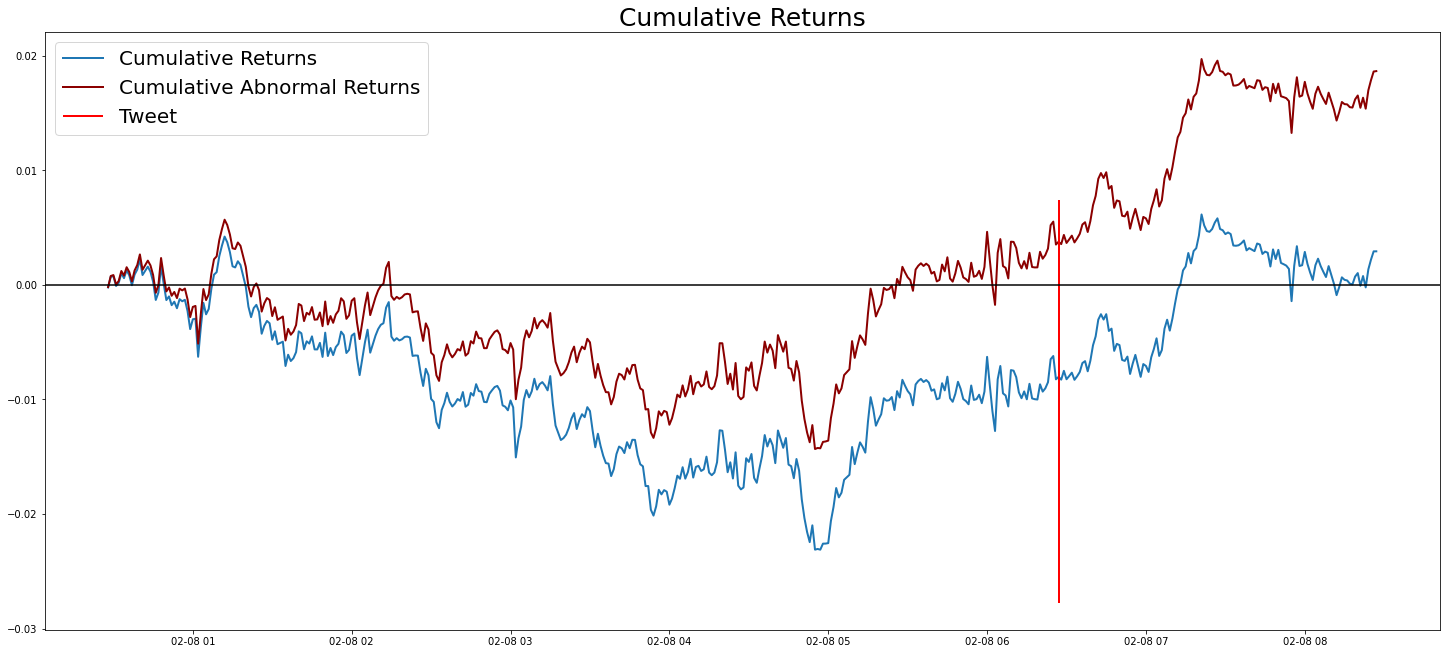

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0


Expected Return =  1.6185860934175017e-05
T[0; 1] =  1.9680084838667056
T[0; 5] =  0.7847762301302431
T[0; 10] =  0.8405360578491634
T[0; 30] =  0.6897716937004076
T[0; 60] =  0.004922454196945295
T[0; 120] =  0.06369895437393511


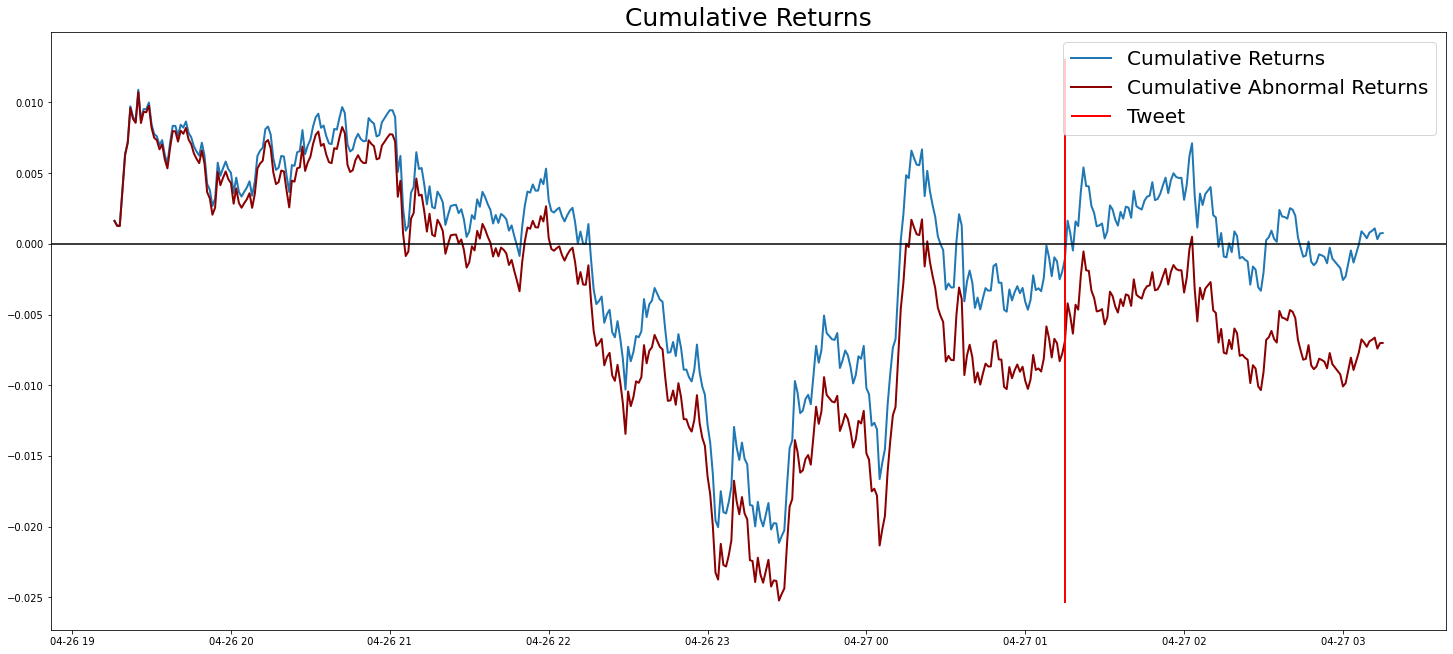

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0


Expected Return =  4.376896520752517e-05
T[0; 1] =  -0.00850697933021329
T[0; 5] =  -0.43889979760270353
T[0; 10] =  -0.18223187724538176
T[0; 30] =  -1.4851619307156743
T[0; 60] =  -0.9456247461899305
T[0; 120] =  -1.1757504693661325


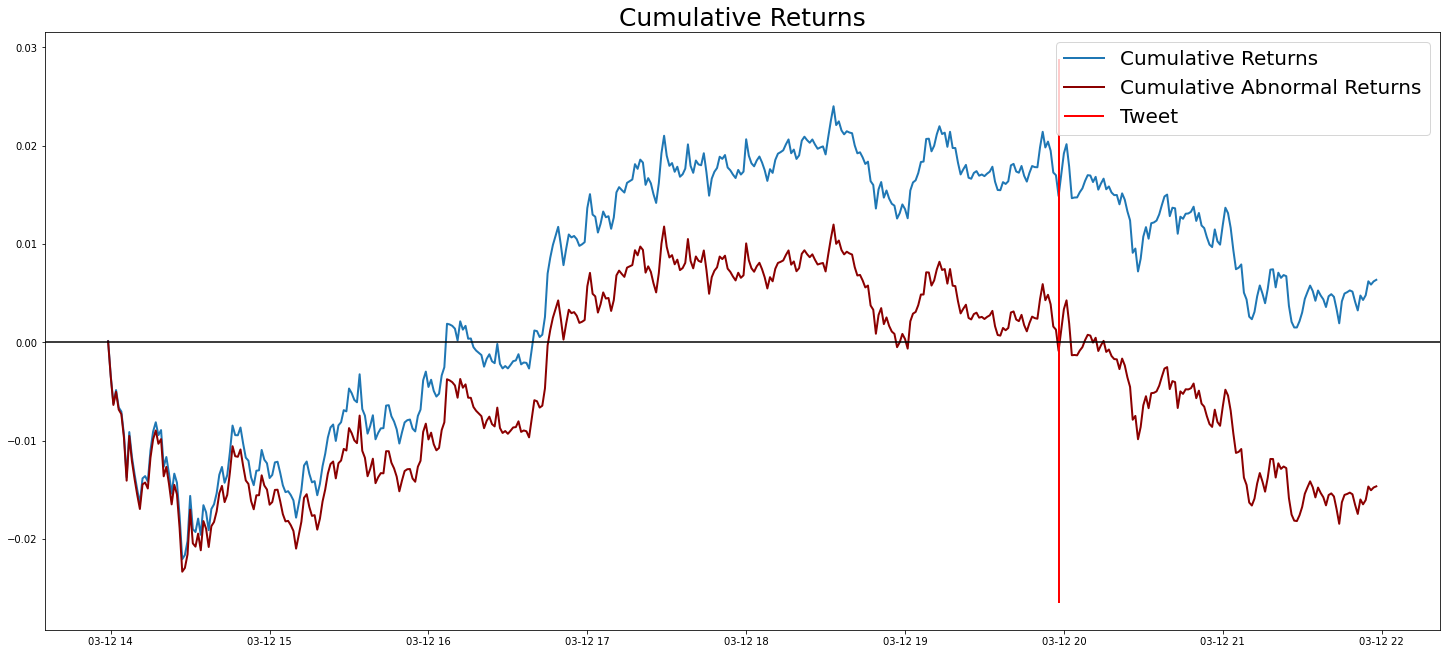

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\2690023036.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0


Expected Return =  -6.783574621180515e-05
T[0; 1] =  -0.8610718092778838
T[0; 5] =  -1.7345142437956014
T[0; 10] =  -1.0207866541527018
T[0; 30] =  -1.3710852850815833
T[0; 60] =  -0.9133482038214915
T[0; 120] =  -1.8467429456448003


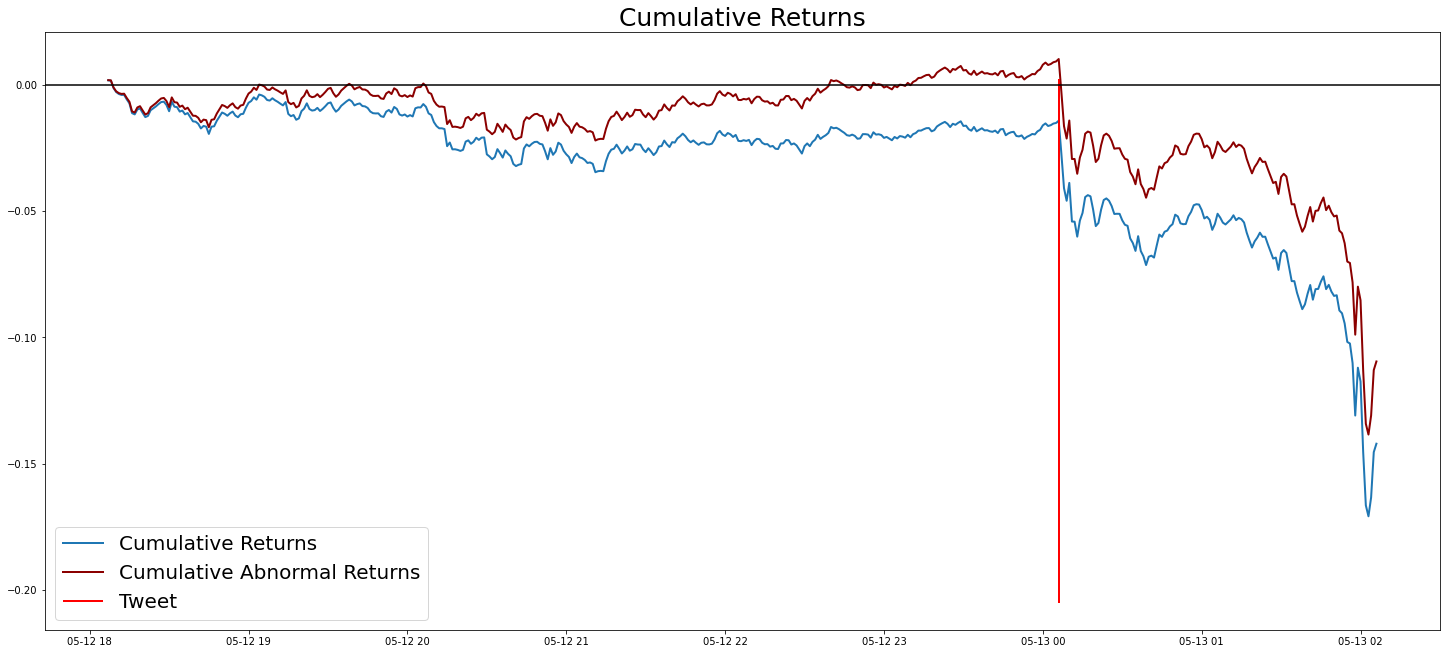

ar_frame:
       AR_0      AR_1      AR_2      AR_3      AR_4      AR_5      AR_6  \
0  -0.00054 -0.001128 -0.000219 -0.000539 -0.000052 -0.000348  0.000234   
1 -0.000557   0.00033 -0.001134  0.001204  0.001253 -0.001927 -0.000224   
2  0.000244 -0.000204  0.000799 -0.000701  0.000308  0.000332 -0.000592   
3  0.000871   0.00267 -0.000892 -0.001251  0.002044 -0.000348  0.002429   
4  -0.00216  0.002124  0.002117    0.0009 -0.002345 -0.003239  0.000026   
5  0.000966 -0.012934 -0.013628  -0.00494  0.007154 -0.015236  0.000015   

       AR_7      AR_8      AR_9     AR_10  
0 -0.001221 -0.001389 -0.001479 -0.000415  
1 -0.001122 -0.001816  0.001667 -0.000758  
2  0.000346  0.000402  0.000816  0.000198  
3  0.001686 -0.001331  -0.00004 -0.001407  
4 -0.000034  0.000481  0.000351  0.000712  
5 -0.005868  0.006444  0.003087  0.006351  
car_frame:
      CAR_1     CAR_2     CAR_5    CAR_10    CAR_30    CAR_60   CAR_120
0 -0.001668 -0.001887 -0.002826 -0.007096  -0.00493 -0.007299 -0.005485
1

In [59]:
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))


ar_ges = pd.DataFrame(columns=['AR_0', 'AR_1', 'AR_2', 'AR_3', 'AR_4', 'AR_5', 'AR_6', 'AR_7', 'AR_8', 'AR_9', 'AR_10', ])
car_ges = pd.DataFrame(columns = ['CAR_1', 'CAR_2', 'CAR_5', 'CAR_10', 'CAR_30', 'CAR_60', 'CAR_120'])

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]
    # Es werden nach Tweets gesucht, die 240 Minuten vor und 100 Minuten nach dem Event stattgefunden haben.
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-240*60) & (df_tweets['timestamp'] <= timestamp+100*60)]
    
    # Ausrechnen der Renditen
    doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
    # Erste Rendite wird 0 gesetzt
    doge_sliced.loc[0, 'log_returns'] = 0
    # Kumulierte Renditen
    doge_sliced['cum_log_returns'] = np.cumsum(doge_sliced['log_returns'])

    # Expected Returns which are based on the mean value of the returns of the last 5 hours before the tweet.
    # Event Takes place at t=360
    expected_return = np.mean(doge_sliced['log_returns'].iloc[1:301]) # Fehler bei Ante, da Ante 1:301 nimmt und nicht 0:300
    print('Expected Return = ', expected_return)
    
    # Abnormal Returns based on After Returns - Mean Value of Returns (before Tweet)
    doge_sliced['abnormal_returns'] = doge_sliced['log_returns'] - expected_return
    doge_sliced['abnormal_returns_cum'] = np.cumsum(doge_sliced['abnormal_returns'])


    ar_values = []
    for event_horizon in range(11):
        ar_values.append(doge_sliced['abnormal_returns'].iloc[360+event_horizon])
    ar_ges = pd.concat([ar_ges, pd.DataFrame([ar_values], columns=ar_ges.columns)], ignore_index=True)


    car_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        car_values.append(doge_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].sum())
    car_ges = pd.concat([car_ges, pd.DataFrame([car_values], columns=car_ges.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    for event_horizon in [1, 5, 10, 30, 60, 120]:
        print(f'T[0; {event_horizon}] = ', (doge_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].mean() / doge_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1)) # <-- richtiger Wert
        
    fig = plt.figure(1, figsize = (25, 11))
    plt.plot(doge_sliced["Date"], doge_sliced['cum_log_returns'], lw=2, label='Cumulative Returns')
    plt.plot(doge_sliced["Date"], doge_sliced['abnormal_returns_cum'], lw=2, label='Cumulative Abnormal Returns', color='darkred')
    plt.vlines(dt.fromtimestamp(timestamp), label='Tweet', ymin=doge_sliced['cum_log_returns'].min()*1.2, ymax=doge_sliced['cum_log_returns'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        plt.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=doge_sliced['abnormal_returns_cum'].max()*1.2, colors='orange', lw=2) 
    plt.axhline(0, color = 'black')
    plt.legend(loc='best', fontsize=20)
    plt.title('Cumulative Returns', size=25)

    plt.show()

print('ar_frame:')
print(ar_ges)

print('car_frame:')
print(car_ges)

In [70]:
ar_ges.to_csv('ar_ges_bitcoin.csv', index=False)
car_ges.to_csv('car_ges_bitcoin.csv', index=False)

In [68]:

for s in ar_ges.columns:
    print(s)
    print('mean: ', ar_ges[s].mean())
    print('pos: ', sum(ar_ges[s] > 0) / len(ar_ges[s]))
    print('t-stat: ' ,ar_ges[s].mean() / ar_ges[s].std() * np.sqrt(len(ar_ges[s])))

    test_statistic, p_value = wilcoxon(ar_ges[s], method='approx', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(ar_ges[s].mean()*100, 4), '\% & ', 
          np.round(ar_ges[s].mean() / ar_ges[s].std() * np.sqrt(len(ar_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(ar_ges[s] > 0) / len(ar_ges[s])*100, 0)), '\%')
    print('\n')

AR_0
mean:  -0.00019618762864682528
pos:  0.5
t-stat:  -0.41243406515580394
z-stat: 10.0
p-Wert: 0.916511907863894
-0.0196 \% &  -0.41  &  10.0  &  50 \%


AR_1
mean:  -0.0015235489617774524
pos:  0.5
t-stat:  -0.6468329538450933
z-stat: 10.0
p-Wert: 0.916511907863894
-0.1524 \% &  -0.65  &  10.0  &  50 \%


AR_2
mean:  -0.002159698323375777
pos:  0.3333333333333333
t-stat:  -0.9209050687052388
z-stat: 7.0
p-Wert: 0.463071015014588
-0.216 \% &  -0.92  &  7.0  &  33 \%


AR_3
mean:  -0.0008880217192897825
pos:  0.3333333333333333
t-stat:  -0.9870922245971985
z-stat: 7.0
p-Wert: 0.463071015014588
-0.0888 \% &  -0.99  &  7.0  &  33 \%


AR_4
mean:  0.0013936595287770282
pos:  0.6666666666666666
t-stat:  1.0702157460786987
z-stat: 6.0
p-Wert: 0.3454475304692257
0.1394 \% &  1.07  &  6.0  &  67 \%


AR_5
mean:  -0.003460978430316211
pos:  0.16666666666666666
t-stat:  -1.433665121312901
z-stat: 1.0
p-Wert: 0.046399461870904594
-0.3461 \% &  -1.43  &  1.0  &  17 \%


AR_6
mean:  0.00031451910

In [69]:
for s in car_ges.columns:
      print(s)
      print('mean: ', car_ges[s].mean())
      print('pos: ', sum(car_ges[s] > 0) / len(car_ges[s]))
      print('t-stat: ' ,car_ges[s].mean() / car_ges[s].std() * np.sqrt(len(car_ges[s])))

      test_statistic, p_value = wilcoxon(car_ges[s], method='approx', alternative='two-sided')

      # Gib die Teststatistik und den p-Wert aus
      print("z-stat:", test_statistic)
      print("p-Wert:", p_value)
      print(np.round(car_ges[s].mean()*100, 4), '\% & ', 
            np.round(car_ges[s].mean() / car_ges[s].std() * np.sqrt(len(car_ges[s])), 2), ' & ',
            np.round(test_statistic, 2), ' & ',
            int(np.round(sum(car_ges[s] > 0) / len(car_ges[s])*100, 0)), '\%')
      print('\n')

CAR_1
mean:  -0.0017197365904242777
pos:  0.3333333333333333
t-stat:  -0.7935784921292188
z-stat: 7.0
p-Wert: 0.463071015014588
-0.172 \% &  -0.79  &  7.0  &  33 \%


CAR_2
mean:  -0.0038794349138000553
pos:  0.5
t-stat:  -0.8804866248778958
z-stat: 10.0
p-Wert: 0.916511907863894
-0.3879 \% &  -0.88  &  10.0  &  50 \%


CAR_5
mean:  -0.00683477553462902
pos:  0.3333333333333333
t-stat:  -1.0644628639476859
z-stat: 6.0
p-Wert: 0.3454475304692257
-0.6835 \% &  -1.06  &  6.0  &  33 \%


CAR_10
mean:  -0.005577059562350107
pos:  0.3333333333333333
t-stat:  -1.1421633482301208
z-stat: 6.0
p-Wert: 0.3454475304692257
-0.5577 \% &  -1.14  &  6.0  &  33 \%


CAR_30
mean:  -0.009128062711456005
pos:  0.3333333333333333
t-stat:  -1.2889941009293875
z-stat: 4.0
p-Wert: 0.17295491798842066
-0.9128 \% &  -1.29  &  4.0  &  33 \%


CAR_60
mean:  -0.006039434762064209
pos:  0.3333333333333333
t-stat:  -0.9523667241780008
z-stat: 6.0
p-Wert: 0.3454475304692257
-0.6039 \% &  -0.95  &  6.0  &  33 \%


CAR

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\1484456187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


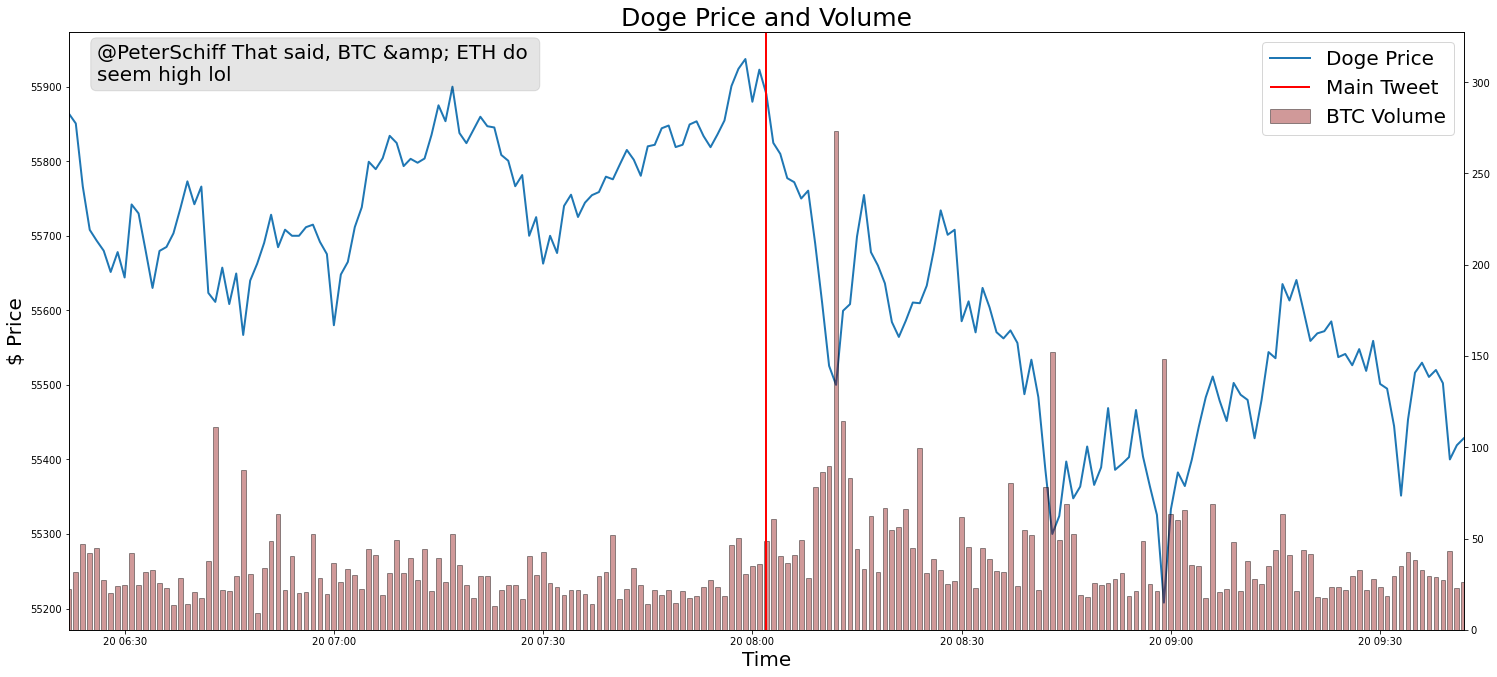

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\1484456187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value
C:\Users\ckopp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


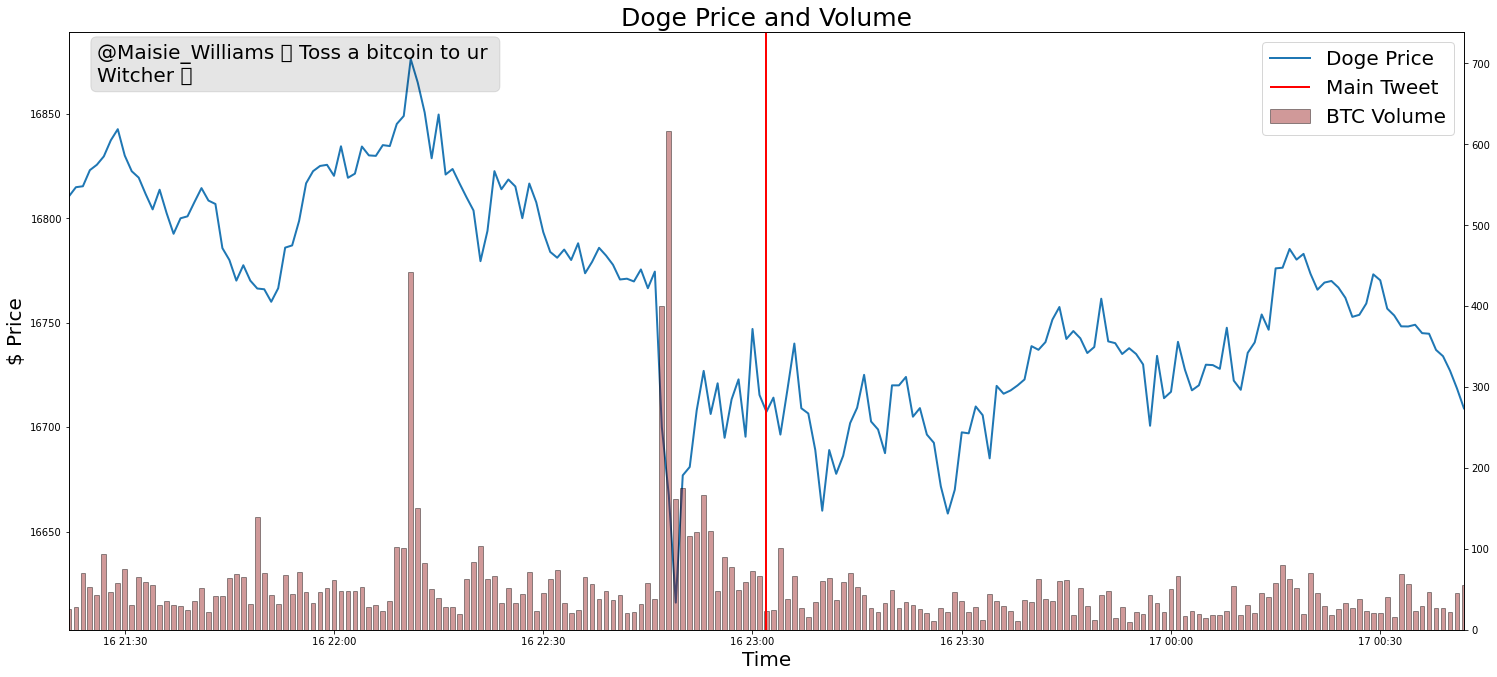

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\1484456187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


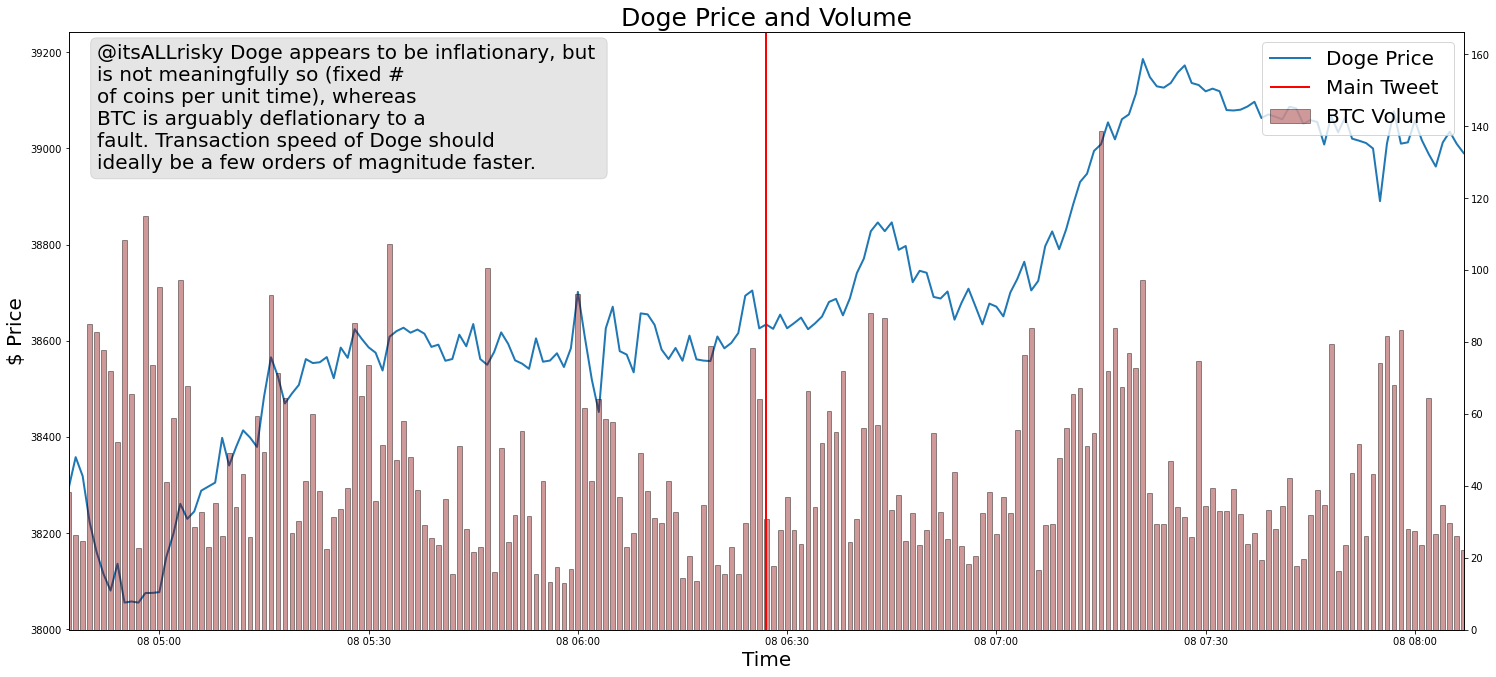

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\1484456187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


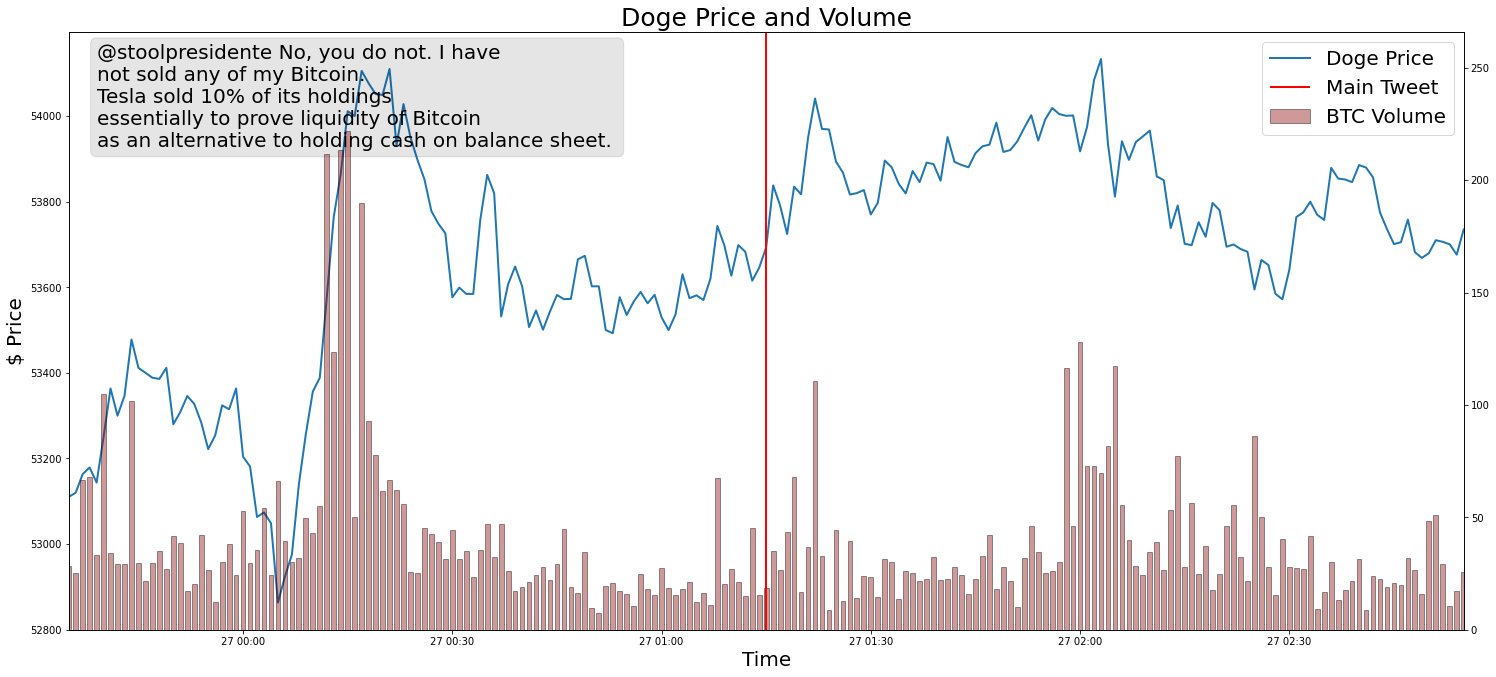

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\1484456187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


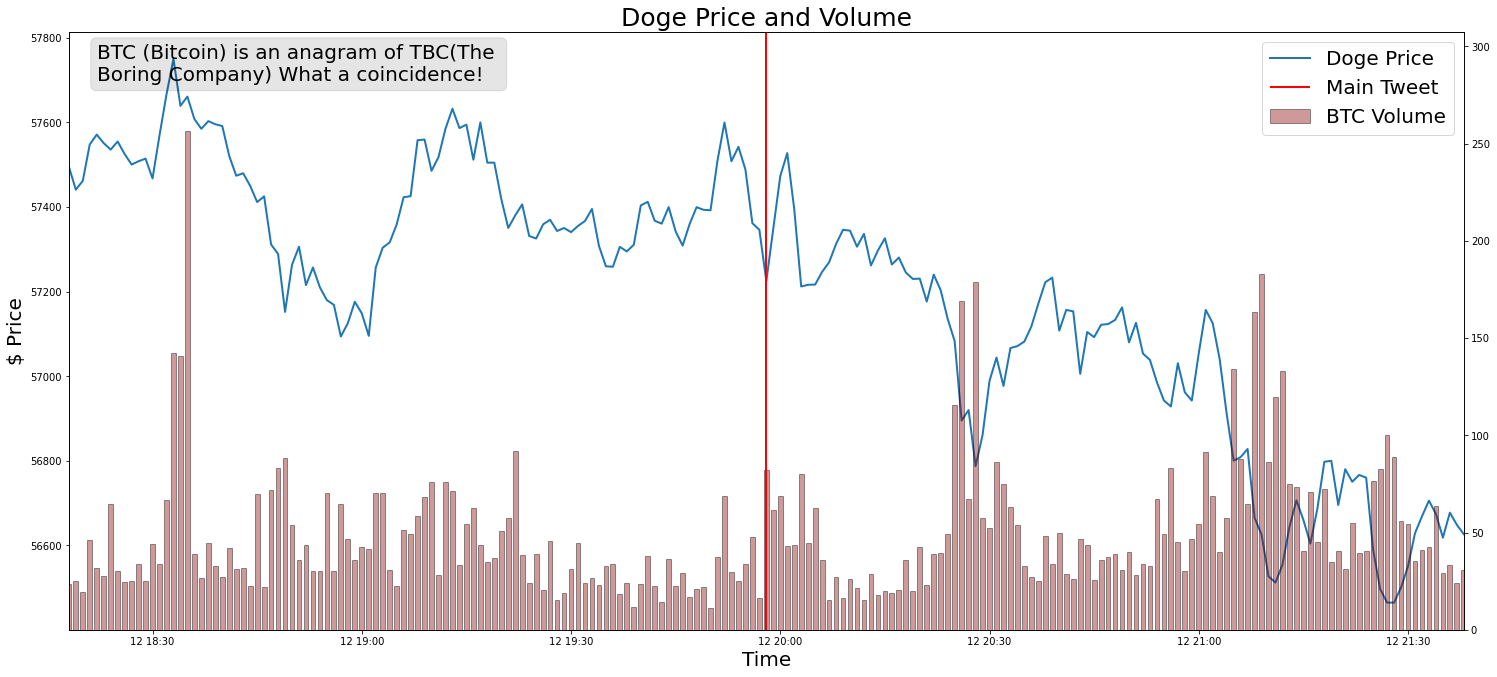

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\1484456187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


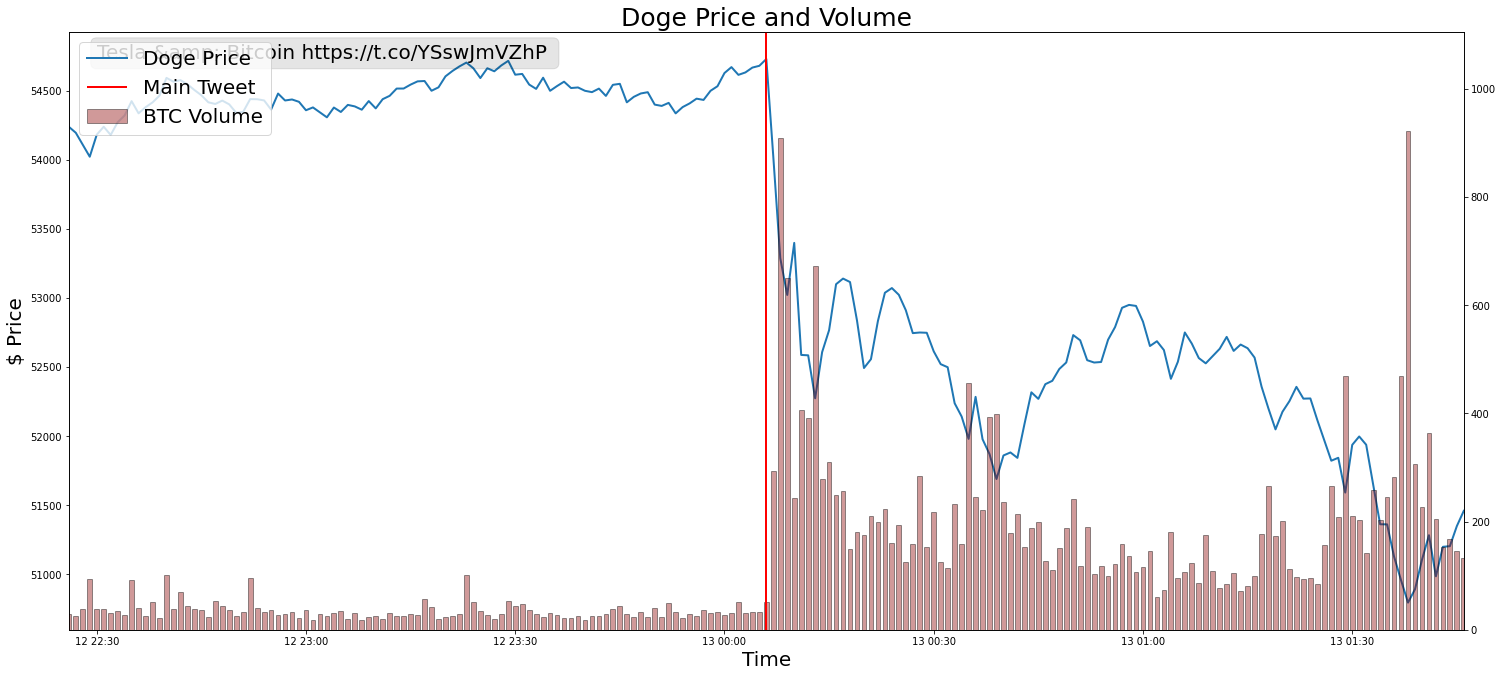

In [8]:
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-100*60) & (df['timestamp'] <= timestamp+100*60)]
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-100*60) & (df_tweets['timestamp'] <= timestamp+100*60)]

    base_value = doge_sliced.iloc[0, 4]
    doge_sliced['CAR'] = doge_sliced['Close']/base_value

    fig = plt.figure(1, figsize = (25, 11))
    ax = fig.add_subplot(111)
    ax.plot(doge_sliced['Date'], doge_sliced['Close'], lw=2, label="Doge Price")

    ax2 = ax.twinx()
    ax2.bar(doge_sliced['Date'], doge_sliced['Volume'], label="BTC Volume", color='darkred', alpha=0.4, width=1/(35*60), edgecolor='black')
    ax2.vlines(dt.fromtimestamp(timestamp), label='Main Tweet', ymin=0, ymax=doge_sliced['Volume'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        ax2.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=doge_sliced['Volume'].max()*1.2, colors='orange', lw=2) 
   
    ax2.set_ylim(0, doge_sliced['Volume'].max()*1.2)
    ax.set_xlim(min(doge_sliced['Date']), max(doge_sliced['Date']))
    ax.set_xlabel("Time", size=20)
    ax.set_ylabel("$ Price", size=20)

    t = [i + ' ' for i in tweet['Text'].split()]
    for i in range(7, len(t), 7):
        t.insert(i, '\n')
    anno = ''.join(t)

    ax.text(0.02, 0.98, anno, transform=ax.transAxes, bbox={'boxstyle':'round', 'facecolor':'black', 'alpha':0.1}, fontsize = 20, va='top')
    

    li, la = ax.get_legend_handles_labels()
    li2, la2 = ax2.get_legend_handles_labels()
    plt.legend(li+li2, la+la2, loc='best', fontsize = 20)
    # plt.legend(loc='best', fontsize=20)
    plt.title('Doge Price and Volume', size=25)

    plt.show()

    #print(tweet['Text'])

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:29: SettingWithCopyWarning: 
A value 

Expected Volume =  -0.0027862135737159216
T[0; 1] =  5.853251918517251
T[0; 5] =  0.5084679145938361
T[0; 10] =  1.2245054674196316
T[0; 30] =  -0.11875524180574344
T[0; 60] =  0.15380784223203728
T[0; 120] =  0.07489495345105829


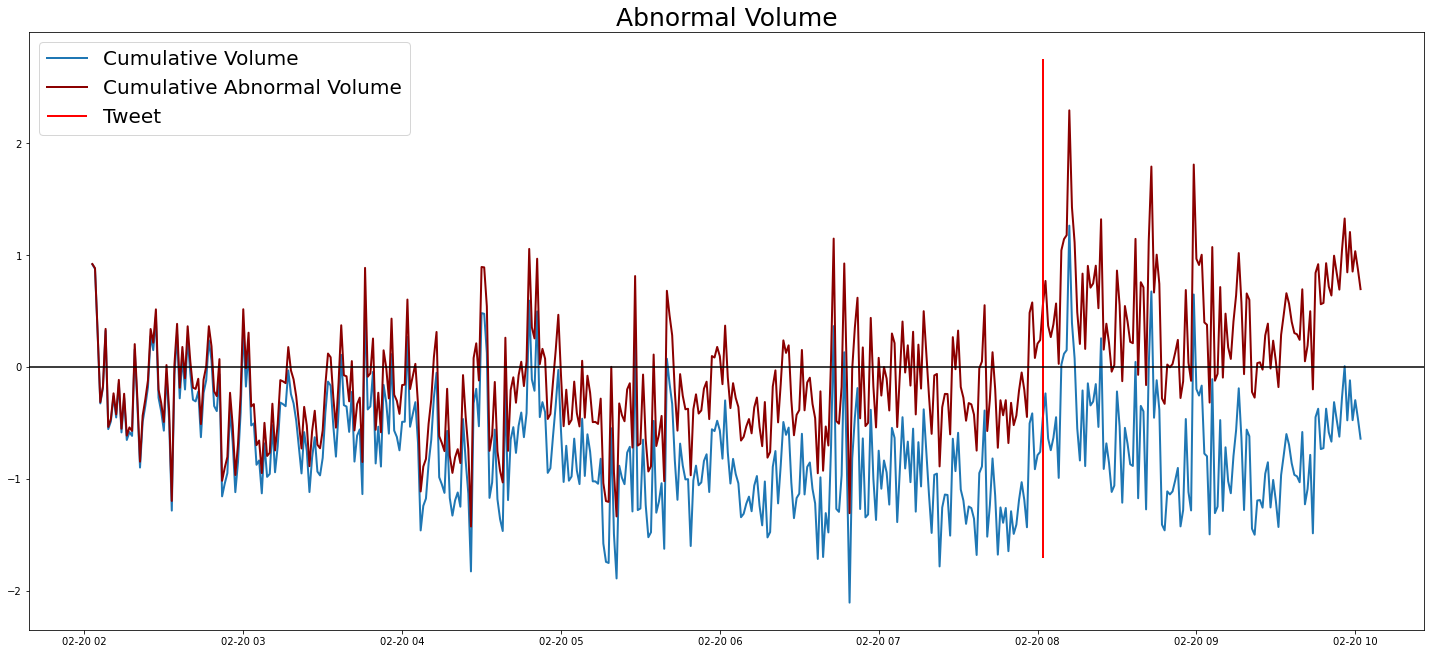

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:29: SettingWithCopyWarning: 
A value 

Expected Volume =  -0.00113047586461574
T[0; 1] =  -0.8745325364951387
T[0; 5] =  -0.3609568895221018
T[0; 10] =  -0.21806580949573098
T[0; 30] =  -0.24981283971218995
T[0; 60] =  -0.2366965259999691
T[0; 120] =  0.02798799322398582


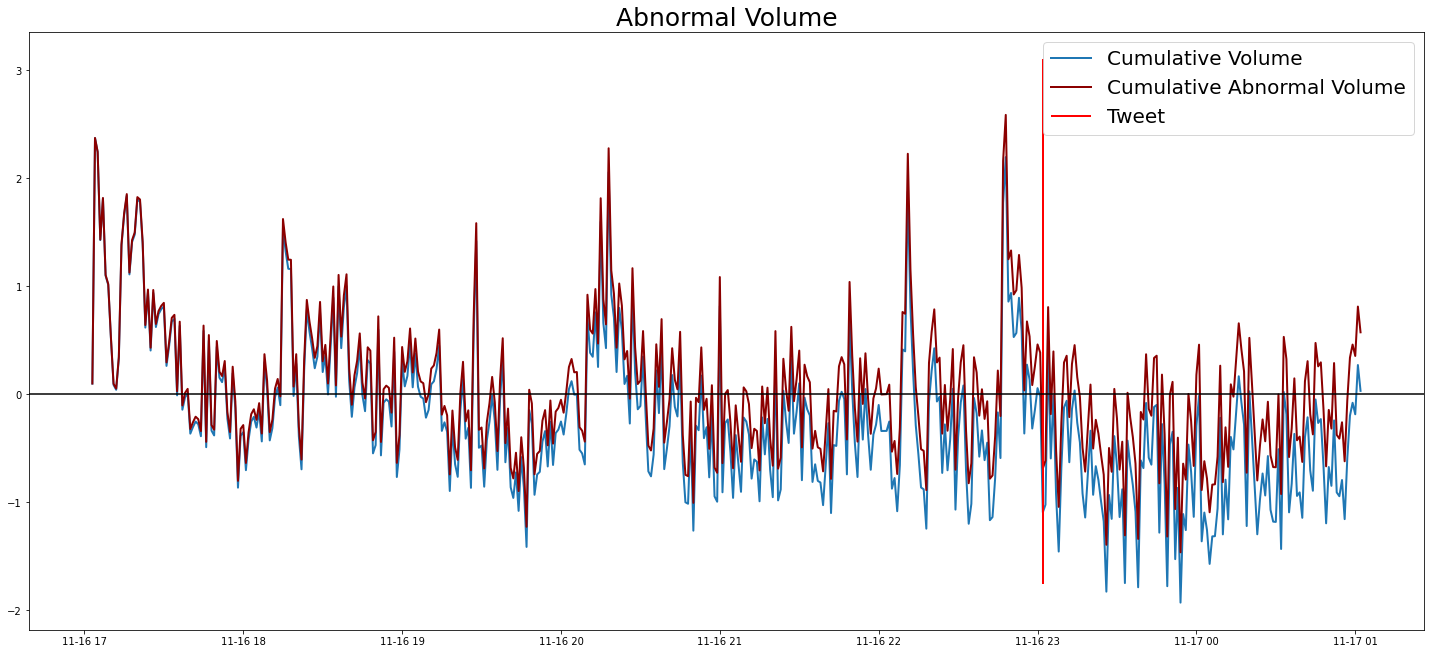

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:29: SettingWithCopyWarning: 
A value 

Expected Volume =  -0.00015411649201966165
T[0; 1] =  -7.135846638367549
T[0; 5] =  -0.8740329564160386
T[0; 10] =  -0.08455481157738923
T[0; 30] =  -0.3929633283378301
T[0; 60] =  -0.17788266774770595
T[0; 120] =  -0.09862637662735763


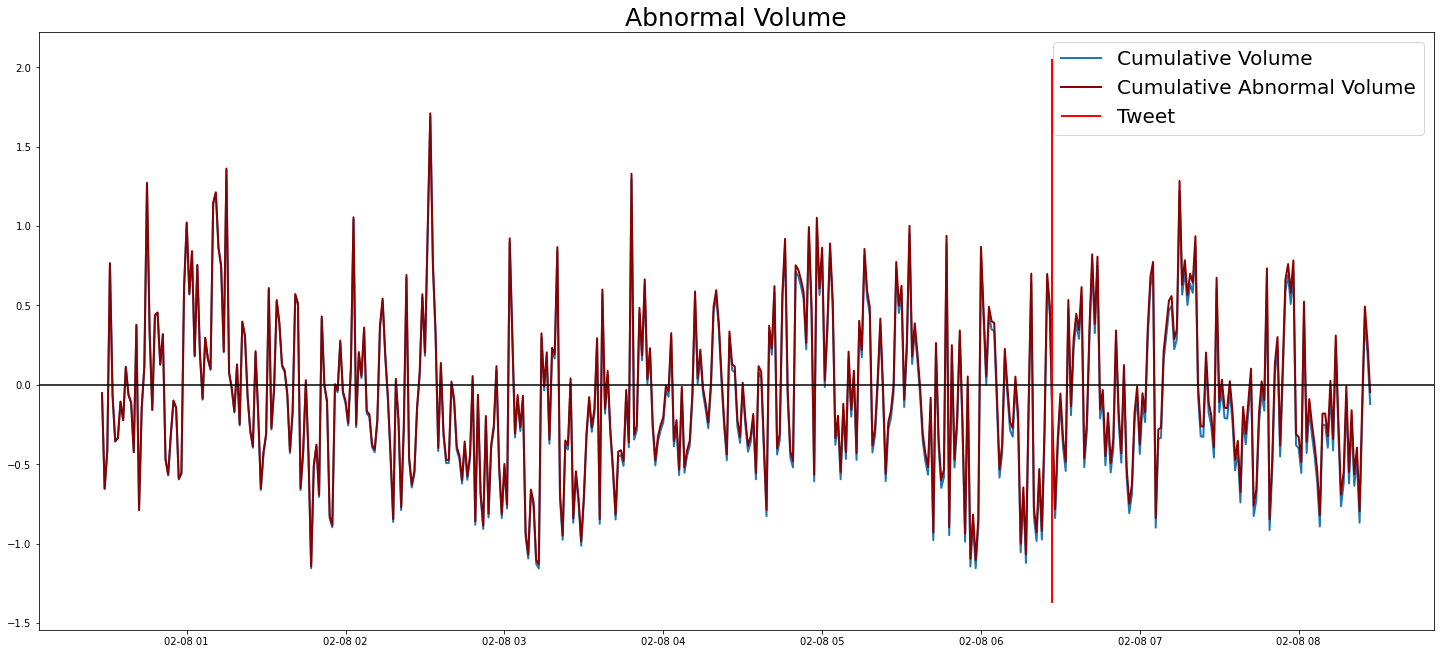

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:29: SettingWithCopyWarning: 
A value 

Expected Volume =  0.007383193326218261
T[0; 1] =  1.7662390045389798
T[0; 5] =  0.024551506558473317
T[0; 10] =  0.2888360091003291
T[0; 30] =  0.035493362936620684
T[0; 60] =  0.025464890138099824
T[0; 120] =  -0.035674392897678354


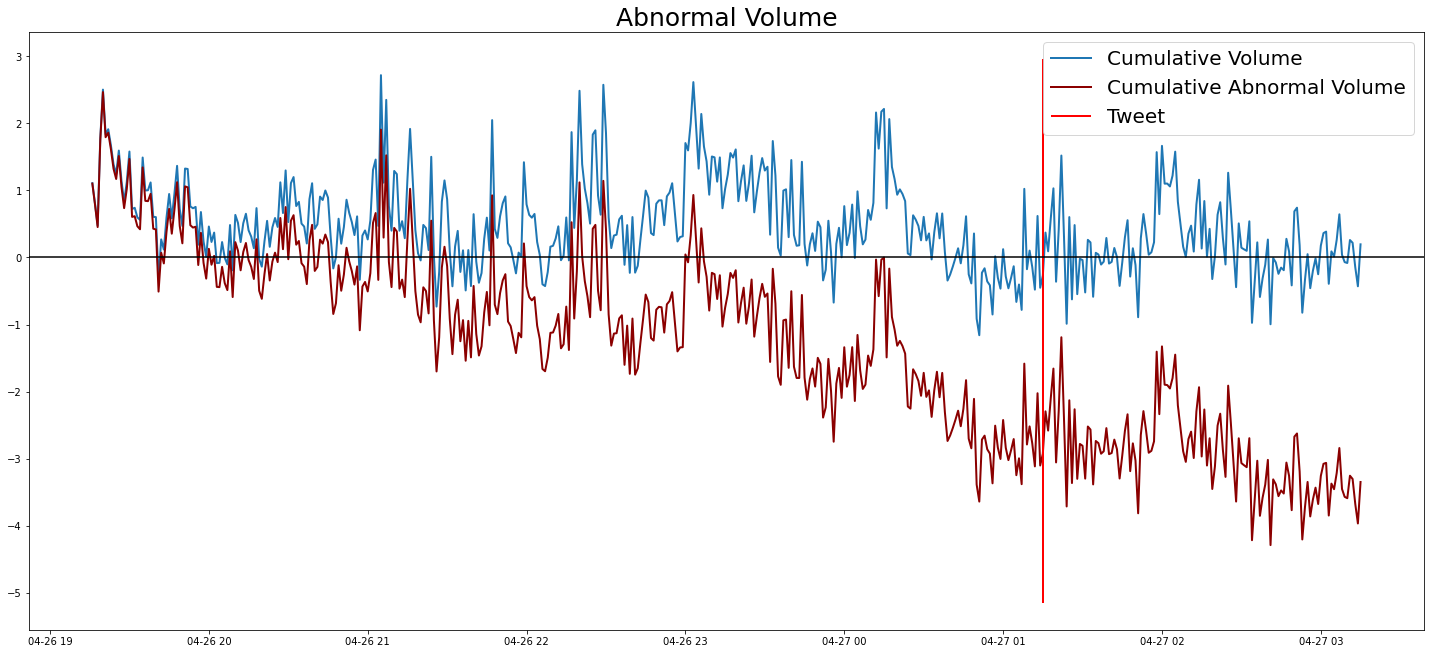

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:29: SettingWithCopyWarning: 
A value 

Expected Volume =  0.0017945277539612899
T[0; 1] =  0.6931837156592805
T[0; 5] =  0.849262344772662
T[0; 10] =  0.21120484051901992
T[0; 30] =  0.697963591975748
T[0; 60] =  0.1220714675123857
T[0; 120] =  0.07850528523823083


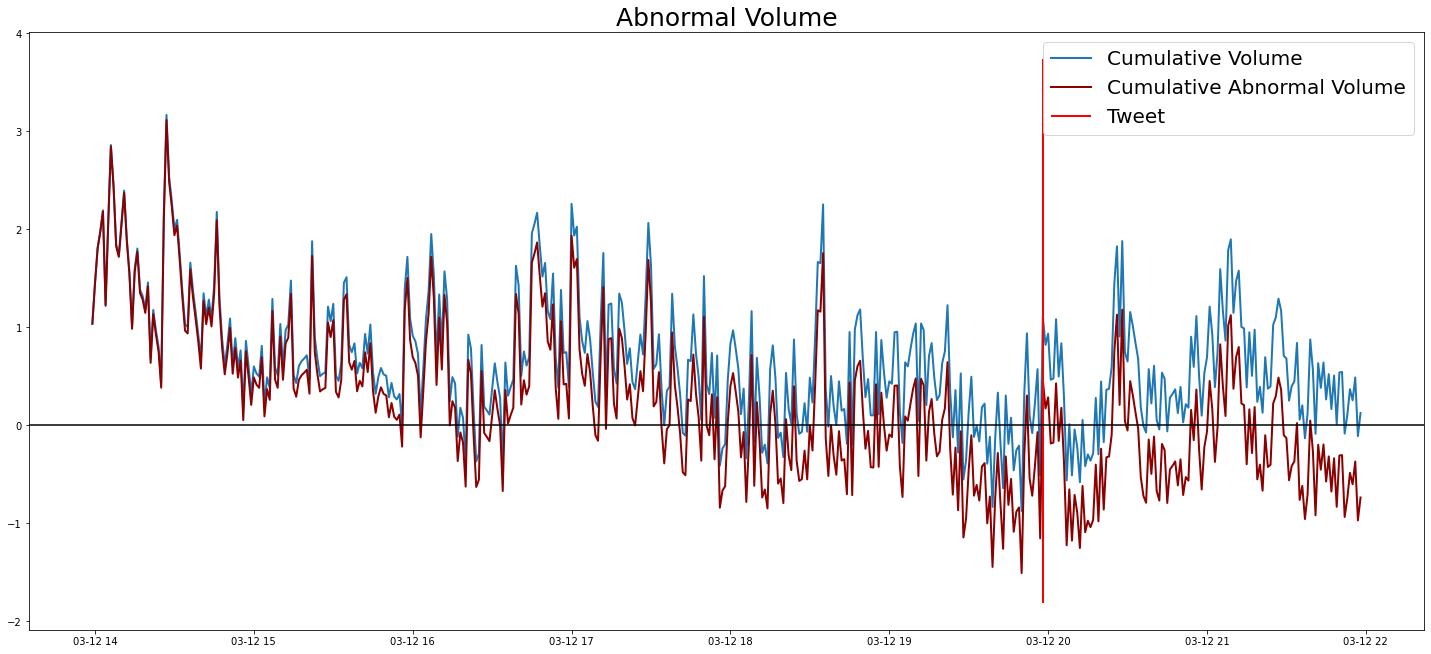

C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_20088\3964933627.py:29: SettingWithCopyWarning: 
A value 

Expected Volume =  -0.00331878088471555
T[0; 1] =  1.76094733407759
T[0; 5] =  1.0565715260422817
T[0; 10] =  0.7652186426442804
T[0; 30] =  0.6209034847372252
T[0; 60] =  0.33795564403965084
T[0; 120] =  0.6040096581736801


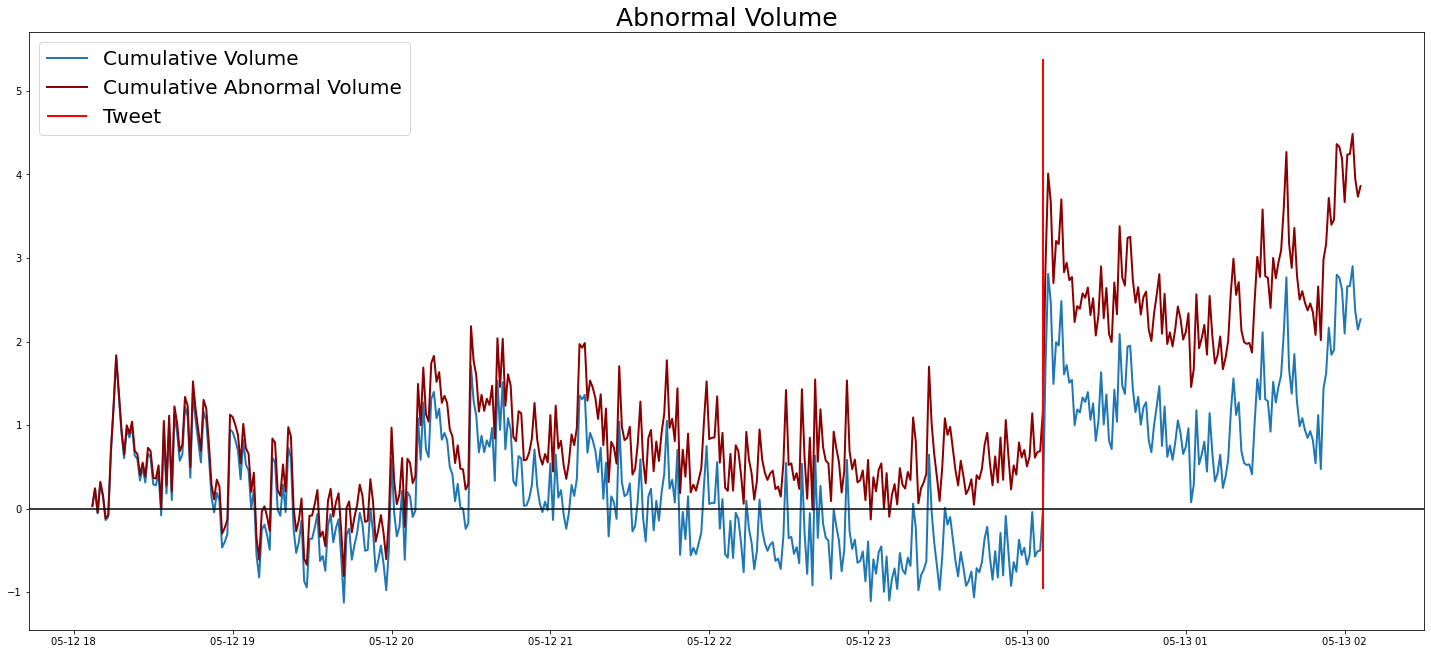

atv_frame:
      ATV_0     ATV_1     ATV_2     ATV_3     ATV_4     ATV_5     ATV_6  \
0  0.309521  0.219193 -0.400554 -0.101724  0.114558  0.185941  -0.53988   
1 -1.072545  0.071788  1.422068 -0.991431  0.580828  -0.91188 -0.527953   
2 -0.730472 -0.550903  0.446626  0.281575 -0.280386 -0.150208  1.020063   
3   0.17518  0.632426 -0.286653   0.48482  0.439276 -1.399262  0.768038   
4  1.618543 -0.293291  0.113241 -0.471414   0.01014  0.604053 -0.587564   
5  0.476572  1.729148  1.117255 -0.340387 -0.970862  0.503599 -0.036211   

      ATV_7     ATV_8     ATV_9    ATV_10  
0  1.015065  0.100465  0.035203  1.116162  
1  0.780451  0.556987  0.062493 -0.568168  
2 -0.668956  0.424784  0.156346 -0.099951  
3  1.098274 -1.225919 -1.296973  1.583008  
4  0.337479 -0.559657 -0.842174  0.570402  
5  0.534437 -0.873323  0.113988 -0.207686  
catv_frame:
     CATV_1    CATV_2    CATV_5   CATV_10   CATV_30   CATV_60  CATV_120
0  0.528715  0.128161  0.326937  2.053951 -0.367773  0.762923  0.455311

In [82]:
# Volume
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))


atv_ges = pd.DataFrame(columns=['ATV_0', 'ATV_1', 'ATV_2', 'ATV_3', 'ATV_4', 'ATV_5', 'ATV_6', 'ATV_7', 'ATV_8', 'ATV_9', 'ATV_10'])
catv_ges = pd.DataFrame(columns = ['CATV_1', 'CATV_2', 'CATV_5', 'CATV_10', 'CATV_30', 'CATV_60', 'CATV_120'])

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]
    # Es werden nach Tweets gesucht, die 240 Minuten vor und 100 Minuten nach dem Event stattgefunden haben.
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-240*60) & (df_tweets['timestamp'] <= timestamp+100*60)]
    
    # Ausrechnen der Renditen
    doge_sliced["log_vol"] = np.log((doge_sliced['Quote Asset Volume']+1) / (doge_sliced['Quote Asset Volume'].shift(1)+1))
    
    ###################################################################################################################
    # Kumulierte Renditen
    doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
    ###################################################################################################################


    # Expected Volume which are based on the mean value of the returns of the last 5 hours before the tweet.
    # Event Takes place at t=360
    expected_volume = np.mean(doge_sliced['log_vol'].iloc[:301]) # Fehler bei Ante, da Ante 1:301 nimmt und nicht 0:300? --> Upper bound excluded
    print('Expected Volume = ', expected_volume)
    
    # Abnormal Returns based on After Returns - Mean Value of Returns (before Tweet)
    doge_sliced['abnormal_volume'] = doge_sliced['log_vol'] - expected_volume
    doge_sliced['abnormal_volume_cum'] = np.cumsum(doge_sliced['abnormal_volume'])


    atv_values = []
    for event_horizon in range(11):
        atv_values.append(doge_sliced['abnormal_volume'].iloc[360+event_horizon])
    atv_ges = pd.concat([atv_ges, pd.DataFrame([atv_values], columns=atv_ges.columns)], ignore_index=True)


    catv_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        catv_values.append(doge_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].sum())
    catv_ges = pd.concat([catv_ges, pd.DataFrame([catv_values], columns=catv_ges.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    for event_horizon in [1, 5, 10, 30, 60, 120]:
        print(f'T[0; {event_horizon}] = ', (doge_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].mean() / doge_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1)) # <-- richtiger Wert
        
    fig = plt.figure(1, figsize = (25, 11))
    plt.plot(doge_sliced["Date"], doge_sliced['cum_log_vol'], lw=2, label='Cumulative Volume')
    plt.plot(doge_sliced["Date"], doge_sliced['abnormal_volume_cum'], lw=2, label='Cumulative Abnormal Volume', color='darkred')
    plt.vlines(dt.fromtimestamp(timestamp), label='Tweet', ymin=doge_sliced['abnormal_volume_cum'].min()*1.2, ymax=doge_sliced['abnormal_volume_cum'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        plt.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=doge_sliced['abnormal_volume_cum'].max()*1.2, colors='orange', lw=2) 
    plt.axhline(0, color = 'black')
    plt.legend(loc='best', fontsize=20)
    plt.title('Abnormal Volume', size=25)

    plt.show()

print('atv_frame:')
print(atv_ges)

print('catv_frame:')
print(catv_ges)